# CNN Cancer Detection Mini-Project

#### DTSA 5511 Introduction to Deep Learning, Week 3

&nbsp;

<b>Instructions</b>: <i>This Kaggle competition is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others' submissions.</i>

First, I'll import the libraries I need for this project.

In [43]:
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input, layers, models, optimizers
from keras import optimizers

Then, I'll import the data needed for the project. I'm limiting the dataset to just 5,000 images, since training on the full dataset took a very long time to complete.

In [2]:
# This is our folder with all of the data
data_path = "/kaggle/input/histopathologic-cancer-detection"
print("Files in dataset folder:", os.listdir(data_path), '\n')

# The 'train' and 'test' folders have images to be classified by the model
train_path = os.path.join(data_path, "train")
print("Sample images:", os.listdir(train_path)[:5], '\n')

# train_labels.csv provides the labels for training images (1=cancerous, 0=non-cancerous)
labels = pd.read_csv(os.path.join(data_path, "train_labels.csv"))[:5000]
print(labels.head())

Files in dataset folder: ['sample_submission.csv', 'train_labels.csv', 'test', 'train'] 

Sample images: ['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif'] 

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


### Brief description of the problem and data (5 pts)

<b>Instructions</b>: <i>Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.</i>

In this project, I am faced with the challenge problem of classifying images of tumor tissue as either cancerous or non-cancerous. This is a special case where computer vision techniques, like convolutional neural netowrks, could be well-equipped to solve this problem.

First, let's look at a randomly-chosen image and it's label to get a sense for this dataset.

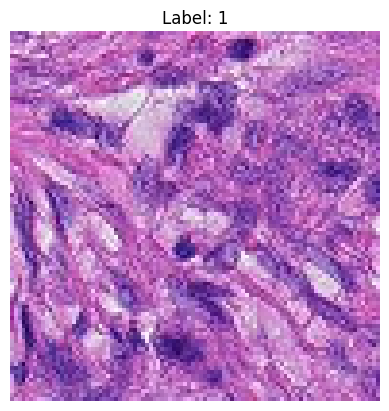

In [3]:
random_index = np.random.randint(0, len(labels))

image_id = labels.iloc[random_index]['id']
label = labels.iloc[random_index]['label']

img_path = f'{data_path}/train/{image_id}.tif'
image = load_img(img_path)

plt.imshow(image)
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

Let's take a look at the size and shape of the data.

In [4]:
num_image_files = len([f for f in os.listdir(f'{data_path}/train/') if f.endswith('.tif')])
print(f"Number of image files: {num_image_files}")

print(f"Labels dataset shape: {labels.shape}")  # Expecting 5,000 rows for the training set

Number of image files: 220025
Labels dataset shape: (5000, 2)


In [5]:
first_image_file = [f for f in os.listdir(f'{data_path}/train/') if f.endswith('.tif')][0]

img_path = os.path.join(f'{data_path}/train/', first_image_file)
image = load_img(img_path)

image_array = img_to_array(image)
print(f"Image shape: {image_array.shape}")

Image shape: (96, 96, 3)


We looks like we have 220,025 images, but I'll only use 5,000 for training, since I don't have a GPU and training on the full 220,025 images was taking too long to complete. The images are 96 pixels by 96 pixels, with three channels (presumably R, G, B). The `labels` dataframe has two columns, one for the image ID, and the other with the label (1 or 0).

It's also worth noting the criteria for an image to be designated as 'cancerous' in this dataset: "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

<b>Instructions</b>: <i>Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?</i>

How balanced is our dataset? Do we have a majority of images that are cancerous or non-cancerous?

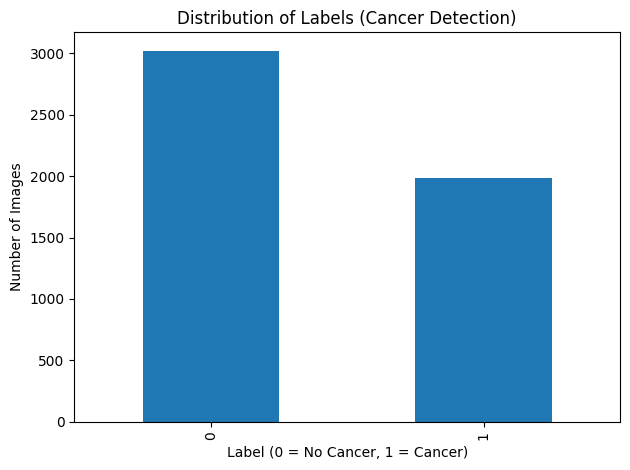

In [6]:
labels['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Labels (Cancer Detection)')
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)')
plt.ylabel('Number of Images')
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

In [7]:
print(labels.describe())

             label
count  5000.000000
mean      0.396200
std       0.489156
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


It looks like the dataset has more non-cancerous images (roughly 60% of the data) than cancerous images (roughly 40% of the data). However, it does not appear to be way out of balance. 

Are there any missing labels we need to handle?

In [8]:
labeled_ids = set(labels['id'])
image_ids_in_folder = set(f.replace('.tif', '') for f in os.listdir(f'{data_path}/train/') if f.endswith('.tif'))
unlabeled_images = image_ids_in_folder - labeled_ids
print(f"Number of image files without a label: {len(unlabeled_images)}")

Number of image files without a label: 215025


Great, I verified that all images in the training set have a label.

What are the ranges of values in the pixels of the images? We'll take a random image and plot a histogram of it's values in each channel.

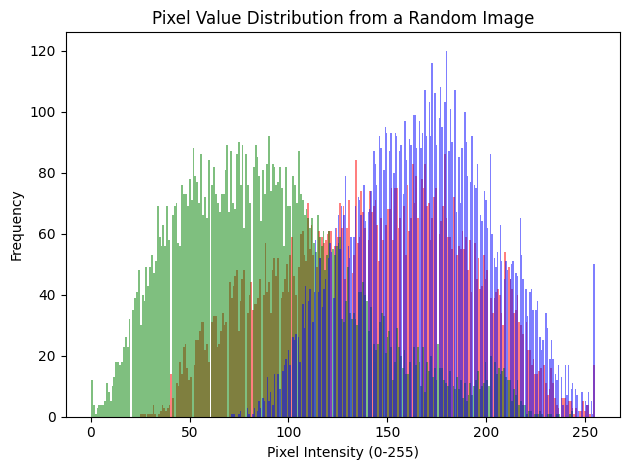

In [9]:
random_index = np.random.randint(0, len(labels))
image_path = os.path.join(f'{data_path}/train/', os.listdir(f'{data_path}/train/')[random_index])
img = load_img(image_path)
img_array = img_to_array(img).astype(np.uint8)

red_channel = img_array[:, :, 0].flatten()
green_channel = img_array[:, :, 1].flatten()
blue_channel = img_array[:, :, 2].flatten()

# Plot histograms
plt.hist(red_channel, bins=256, color='red', alpha=0.5)
plt.hist(green_channel, bins=256, color='green', alpha=0.5)
plt.hist(blue_channel, bins=256, color='blue', alpha=0.5)
plt.title('Pixel Value Distribution from a Random Image')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Looks like the values span from 0 to 255, which is typical for RGB images. However, the model is going to work better if we limit the values to a smaller range, while maintaining the important relationships within the data. I'll make sure to normalize our image data to the range [0, 1] when we train the model.

Lastly, Keras wants the labels to be strings, so I converted the label column in the dataframe to string.

In [10]:
labels['label'] = labels['label'].astype(str)

### Model Architecture (25 pts)

<b>Instructions</b>: <i>Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.</i>

Now that we've explored the data, the data need to be split into training and validation sets for the model.

In [11]:
labels['id'] = labels['id'].astype(str) + '.tif'  # Add .tif to the end of each image ID in the dataframe
train, val = train_test_split(labels, test_size=0.2, stratify=labels['label'], random_state=42)

The data will be fed into the CNN using a generator. Loading all of the images we're going to train with into RAM all at once is overwhelming and slow. The generator avoids this issue by iteratively providing batches of images to the CNN. The generator also scales values from [0, 255] to [0, 1].

In [12]:
# This is the generator that will provide batches of images to the model
# It also handles the normalization step with the rescale parameter
imggen = ImageDataGenerator(rescale=1./255)

In [13]:
# Generator connected to the training set
train_generator = imggen.flow_from_dataframe(
    train,
    directory=f'{data_path}/train/',
    x_col='id',
    y_col='label',
    batch_size=16,
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

# Generator connected to the validation set
val_generator = imggen.flow_from_dataframe(
    val,
    directory=f'{data_path}/train/',
    x_col='id',
    y_col='label',
    batch_size=16,
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


As a baseline, I'll train a simple, feed-forward artificial neural network and see how it performs.

In [14]:
simple_ann = models.Sequential([
    Input(shape=(96, 96, 3)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_ann.compile(
    optimizer=optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

simple_ann_start = time.time()
simple_ann_results = simple_ann.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=20,
    epochs=5,
)
simple_ann_end = time.time()

2025-04-19 01:56:28.976034: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.6198 - loss: 29.1064 - val_accuracy: 0.6040 - val_loss: 9.5016
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.4941 - loss: 4.4153 - val_accuracy: 0.6040 - val_loss: 0.6690
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.5585 - loss: 1.0820 - val_accuracy: 0.6040 - val_loss: 0.8696
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.5000 - loss: 1.1728 - val_accuracy: 0.6040 - val_loss: 0.7236
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.5546 - loss: 0.8169 - val_accuracy: 0.6040 - val_loss: 0.7355


As you can see, the simple, feed-forward neural network didn't perform too well. Since this is a binary classification problem, an accuracy of 0.5 would indicate a model has no skill. This neural network does better than that, with a 0.60 accuracy on the validation dataset. However, we see no indication that the model improves from one epoch to the next.
 
In this week's lectures, we learned about convolutional layers that can be added to neural networks. Convolutional layers apply filters that slide across the input image. They help detect small patterns in the image, like edges, textures, or shapes. These detected features are then passed on to deeper layers, which allow the model to learn increasingly complex representations. I'll try including this in my model architecture:

In [15]:
simple_cnn = models.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_cnn.compile(
    optimizer=optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

simple_cnn.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=10,
    epochs=20,
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 447ms/step - accuracy: 0.5413 - loss: 1.6478 - val_accuracy: 0.6040 - val_loss: 0.6783
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - accuracy: 0.6182 - loss: 0.6672 - val_accuracy: 0.6880 - val_loss: 0.6471
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.5926 - loss: 0.7054 - val_accuracy: 0.6030 - val_loss: 0.6325
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.6814 - loss: 0.6111 - val_accuracy: 0.6040 - val_loss: 0.7864
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.6128 - loss: 0.7545 - val_accuracy: 0.6120 - val_loss: 0.6223
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.6019 - loss: 0.6523 - val_accuracy: 0.6890 - val_loss: 0.6179
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.6104 - loss: 0.6658 - val_accuracy: 0.6190 - val_loss: 0.6174
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.6155 - loss: 0.6123 - val_accuracy: 0.

Ok, we're seeing some progress! I introduced two convolutional layers, followed by two max pooling layers, plus a single dense layer at the end before providing the output. The validation accuracy is getting better. It's above 0.60 for most epochs. However, it bounces around quite a bit from epoch to epoch. This is typically a sign that the learning rate is too high. I'll lower the learning rate and see if that helps.

In [16]:
simple_cnn = models.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_cnn.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

simple_cnn_start = time.time()
simple_cnn_results = simple_cnn.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=40,
    epochs=75,
)
simple_cnn_end = time.time()

Epoch 1/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.5724 - loss: 0.6740 - val_accuracy: 0.6030 - val_loss: 0.6535
Epoch 2/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.5829 - loss: 0.6574 - val_accuracy: 0.6320 - val_loss: 0.6489
Epoch 3/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.6431 - loss: 0.6436 - val_accuracy: 0.6130 - val_loss: 0.6349
Epoch 4/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.6322 - loss: 0.6195 - val_accuracy: 0.6290 - val_loss: 0.6250
Epoch 5/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.6327 - loss: 0.6299 - val_accuracy: 0.6280 - val_loss: 0.6191
Epoch 6/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.6633 - loss: 0.6184 - val_accuracy: 0.6610 - val_loss: 0.6065
Epoch 7/75
10/40 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6419 - loss: 0.6006

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6761 - loss: 0.5796 - val_accuracy: 0.6400 - val_loss: 0.6084
Epoch 8/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.7065 - loss: 0.6024 - val_accuracy: 0.6640 - val_loss: 0.5992
Epoch 9/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.6800 - loss: 0.5879 - val_accuracy: 0.7010 - val_loss: 0.5912
Epoch 10/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.7197 - loss: 0.5716 - val_accuracy: 0.6970 - val_loss: 0.5844
Epoch 11/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.7273 - loss: 0.5613 - val_accuracy: 0.7170 - val_loss: 0.5813
Epoch 12/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.7436 - loss: 0.5600 - val_accuracy: 0.7110 - val_loss: 0.5746
Epoch 13/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.7208 - loss: 0.5665 - val_accuracy: 0.7070 - val_loss: 0.5697
Epoch 14/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7445 - loss: 0.5406 - val_accuracy: 0.7270 - v

The default learning rate in Keras is 0.001. I made it 0.00001. The validation accuracy doesn't swing as wildy between each epoch, but it is still not smooth either. Also, it's important to consider that a slower learning rate requires more epochs to converge. It would be helpful to plot the accuracy from each epoch to understand whether the model is converging.

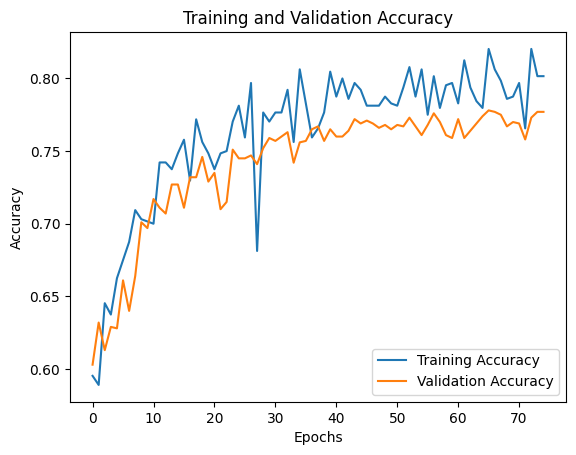

In [17]:
plt.plot(simple_cnn_results.history['accuracy'], label='Training Accuracy')
plt.plot(simple_cnn_results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

It looks like the model is starting to level off around 50 to 70 epochs. Since I have limited computing resources, and especially since I don't have a GPU, it's easier for me to work with models that train faster. Training for 50 epochs or more can take several minutes.

I also want to try batch normalization. This is a technique that normalizes the outputs of layers before activations, which helps activations from getting too large or too small. This can stabilize learning, allowing for higher learning rates and fewer epochs. Let's see how it performs:

In [20]:
batch_cnn = models.Sequential([
    layers.Input(shape=(96, 96, 3)),
    
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(1, activation='sigmoid')
])

batch_cnn.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

batch_cnn_results = batch_cnn.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=40,
    epochs=75,
)

Epoch 1/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.5609 - loss: 0.7256 - val_accuracy: 0.4570 - val_loss: 0.7281
Epoch 2/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.6294 - loss: 0.7273 - val_accuracy: 0.3960 - val_loss: 1.0091
Epoch 3/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.7252 - loss: 0.6142 - val_accuracy: 0.3960 - val_loss: 1.2785
Epoch 4/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.6564 - loss: 0.6500 - val_accuracy: 0.3960 - val_loss: 1.4893
Epoch 5/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.7201 - loss: 0.5393 - val_accuracy: 0.3960 - val_loss: 1.7577
Epoch 6/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.6920 - loss: 0.5918 - val_accuracy: 0.3990 - val_loss: 1.8305
Epoch 7/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6860 - loss: 0.5639 - val_accuracy: 0.4030 - val_loss: 1.9139
Epoch 8/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.7576 - loss: 0.4896 - val_accur

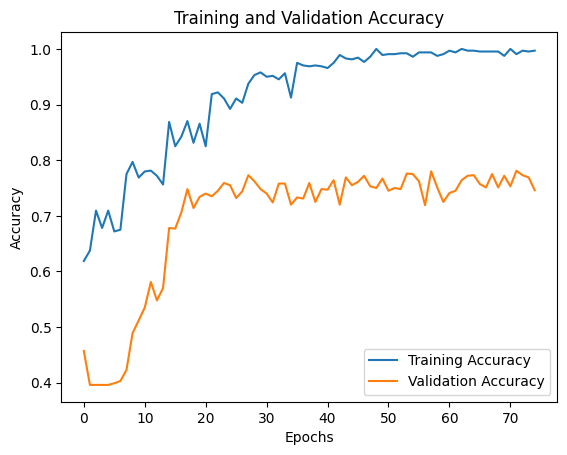

In [21]:
plt.plot(batch_cnn_results.history['accuracy'], label='Training Accuracy')
plt.plot(batch_cnn_results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Batch normalization certainly helped this model reach convergence faster, after just 15 or 20 epochs. I'll limit the model to 20 epochs so that we avoid overfitting.

In [22]:
batch_cnn = models.Sequential([
    layers.Input(shape=(96, 96, 3)),
    
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(1, activation='sigmoid')
])

batch_cnn.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

batch_cnn_start = time.time()
batch_cnn_results = batch_cnn.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=40,
    epochs=20,
)
batch_cnn_end = time.time()

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.5808 - loss: 0.7510 - val_accuracy: 0.5610 - val_loss: 0.6731
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.6557 - loss: 0.6427 - val_accuracy: 0.3960 - val_loss: 0.9658
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.6711 - loss: 0.6344 - val_accuracy: 0.3960 - val_loss: 1.0785
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.6731 - loss: 0.6413 - val_accuracy: 0.4080 - val_loss: 1.2169
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.6424 - loss: 0.6802 - val_accuracy: 0.4340 - val_loss: 1.3198
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.7226 - loss: 0.5706 - val_accuracy: 0.4210 - val_loss: 1.4051
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.7751 - loss: 0.4859 - val_accuracy: 0.4380 - val_loss: 1.4321
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.8017 - loss: 0.4542 - val_accur

The model ended up with a validation accuracy of 0.65, which is much better than the simple neural network, which had a validation accuracy of 0.60. I was also able to achieve this in 20 epochs, which is a manageable number of epochs for my computer.

I'm also curious whether a pretrained model can perform better than this. We talked about VGG and ResNet in the lectures. Let's see how they perform on this task:

In [23]:
vgg = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(96, 96, 3)
)
vgg.trainable = False

vgg = models.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(1, activation='sigmoid')
])

vgg.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

vgg_start = time.time()
vgg_history = vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=40,
    validation_steps=20
)
vgg_end = time.time()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5668 - loss: 0.6907 - val_accuracy: 0.4844 - val_loss: 0.7086
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6716 - loss: 0.6177 - val_accuracy: 0.5781 - val_loss: 0.6770
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6850 - loss: 0.5979 - val_accuracy: 0.6812 - val_loss: 0.6000
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 905ms/step - accuracy: 0.7118 - loss: 0.5644 - val_accuracy: 0.7250 - val_loss: 0.5949
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7332 - loss: 0.5419 - val_accuracy: 0.7125 - val_loss: 0.5755
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7174 - loss: 0.5462 - val_accuracy: 0.6969 - val_loss: 0.5734
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 614ms/step - accuracy: 0.6742 - loss: 0.5731 - val_accuracy: 0.7719 - val_loss: 0.5014
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 907ms/step - accura

Training the VGG model was even slower than the models I built myself, but that is to be expected with a pretrained model. VGG and other pretrained models take advantage of transfer learning. These models were trained on a large dataset, and then can be adapted for other tasks like this one by reusing it's learned features. However, this technique requires a large amount of data to train with in order to see effective results.

The validation accuracy in this VGG model I attempted to use above is very erratic, but also generally between 0.7 and 0.9 for validation accuracy. These results provide promise for folks who can train with more data and use better processors, like GPUs. In my case, this pretrained model ended with a validation accuracy of 0.73, which is slightly better than my "homemade" convolutional neural network.

### Results and Analysis (35 pts)

<b>Instructions</b>: <i>Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.</i>

I already went through iterations of model architecture and tuning hyperparamters, like learning rates, in the preivous section, so I'll focus more on a discussion of the accuracy and performance of the models I trained above.

Here's a summary of the accuracy and training time for each model:

In [24]:
model_summary = pd.DataFrame()
model_summary['Model'] = ['Simple Artificial NN', 'Convolutional NN', 'Convolutional NN w/ Batch Norm.', 'VGG Pre-trained NN']
model_summary['Accuracy'] = [simple_ann_results.history['val_accuracy'][-1],
                             simple_cnn_results.history['val_accuracy'][-1],
                             batch_cnn_results.history['val_accuracy'][-1],
                             vgg_history.history['val_accuracy'][-1]]
model_summary['Training Time (sec)'] = [simple_ann_end - simple_ann_start,
                                        simple_cnn_end - simple_cnn_start,
                                        batch_cnn_end - batch_cnn_start,
                                        vgg_end - vgg_start]
model_summary['Training Batches'] = [5, 75, 20, 10]
model_summary['Training Time per Batch (sec)'] = model_summary['Training Time (sec)'] / model_summary['Training Batches']
model_summary

,Model,Accuracy,Training Time (sec),Training Batches,Training Time per Batch (sec)
0,Simple Artificial NN,0.604000,42.597807,5,8.519561
1,Convolutional NN,0.777000,586.434153,75,7.819122
2,Convolutional NN w/ Batch Norm.,0.652000,207.377116,20,10.368856
3,VGG Pre-trained NN,0.728125,469.761143,10,46.976114


The artificial neural network only implemented dense, feedforward layers, and provided a baseline for the rest of the models I trained. It's accuracy was the poorest, since we know that dense layers can't learn image features well. That's why I then created a convolutional neural network, which performed much better. However, I struggled to get the training to be more stable. I tried a convolutional neural network with batch normalization before each activation. This allowed the model to converge much sooner, which was great. However, it didn't do much to stabilize the training process. I also tried a pretrained model, which had a performance in between my two homemade CNNs, but was also unstable during training, and probably needed more data and computing resources to improve upon.

I tweaked hyperparameters throughout the process, mostly focusing on learning rate and number of epochs until I found a good balance, but I also attempted some work with momentum, decay, and dropout. The balancing act between learning rate and epochs was key to getting the model to converge, but without overfitting.

Let's take a closer look at the performance of the first convolutional neural network I created. I made predictions on the validation set and then put them into a confusion matrix.

In [45]:
y_true = val_generator.classes
y_pred_prob = simple_cnn.predict(val_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       604
           1       0.73      0.70      0.71       396

    accuracy                           0.78      1000
   macro avg       0.77      0.76      0.77      1000
weighted avg       0.78      0.78      0.78      1000



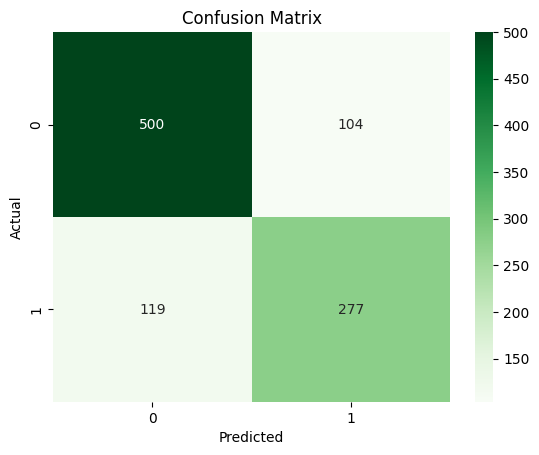

In [42]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Simple CNN Confusion Matrix')
plt.show()

This was my best model, which a validation accuracy of 0.77. We know that the dataset is unbalanced, so there's more class 0 than class 1 samples in the dataset.  The precision and recall are generally around 0.77 as well, so the accuracy measure is a good indicator of the overall skill of the model (it's not the case here that one class is being predicted extremley well, and the other extremeley poorly, which is a situation where accuracy can be a misleading metric).

I'll move forward using the first convolutional neural network and use it to make predictions for the Kaggle challenge.

In [25]:
# Get the names of the images in the test dataset
test_image_dir = f'{data_path}/test/'
test_df = pd.DataFrame({'id': os.listdir(test_image_dir)})

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

# This generator will serve test images to the model to make predictions
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=f'{data_path}/test/',
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=16,
    class_mode=None,
    shuffle=False
)

# Get predictions from test images
predictions = simple_cnn.predict(test_generator)

Found 57458 validated image filenames.
   1/3592 ━━━━━━━━━━━━━━━━━━━━ 10:14 171ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 380s 106ms/step


In [30]:
# Bring predictions together which 
predicted_classes = (predictions > 0.5).astype("int32")
test_df['id'] = test_df['id'].str[:-4]
test_df['label'] = predicted_classes
print(test_df.head())

                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


In [31]:
# Output CSV for submission to competition
test_df.to_csv('submission.csv', index=False)

### Conclusion (15 pts)

<b>Instructions</b>: <i>Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?</i>

Overall, the results showed me the power of convolutional neural networks (CNN). All of the CNNs I trained outperformed the basic artificial neural network, since convolutional layers can pick out patterns from images that a typical dense layer cannot. 

Here's what helped improve the performance of my models (and some lessons learned):
* Including convolutional layers to help with the task of training on image input
* Batch normalization allowed my neural network to converge faster, so I could prototype more quickly to make further improvements
* A lower learning rate is key to finding a minimum without bouncing around and overshooting the minimum of the loss function
* More epochs might be needed if the model is not converging, especially if the learning rate is slow

Here's what didn't help improve the performance of my models (and some lessons learned):
* I was limited to a CPU, so training many epochs across many models took a while and slowed down my progress
* I limited my training set to 5,000 images so that I could train faster, probably at the expense of some model skill and stability
* I couldn't get the momentum parameter on the optomizer to make any meaningful difference in model performance

Here's what I'd like to try in the future:
* I'd like to work with a GPU in the future so I can train models faster and more easily prototype improvements
* I'd like to find an example project where momentum could be more helpful, because I did not see it improve performance when I tried it here
* I'd also like to experiment with data augmentation, which allows you to duplicate images in the training set, except rotated or resized, in order to improve model performance